<a href="https://colab.research.google.com/github/BandaVallary/Movie_Recommendation_System/blob/kelvin/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Movie Recommendation System

!["Image of Donald Draper in a Movie Theater"](https://github.com/BandaVallary/Movie_Recommendation_System/blob/kelvin/images/dondraperinmovietheater.jpg?raw=1)

## Overview

This project aims to develop a recommendation system that provides personalized movie recommendations based on user ratings. Utilizing the [MovieLens dataset](https://web.archive.org/web/20240828133414/https://grouplens.org/datasets/movielens/latest/) from the GroupLens research lab at the University of Minnesota, the model will be trained on a subset of the dataset containing 100,000 user ratings. The primary objective is to build a machine learning model that can accurately recommend the top 5 movies to a user, based on their ratings of other movies. This system can be valuable for streaming platforms and movie enthusiasts, offering tailored movie suggestions to enhance user experience and engagement.

The project will involve several steps, including data cleaning, exploratory data analysis, feature engineering, model selection, and evaluation.

Throughout this project, we will also explore the relationships between different variables and their impact on movie recommendations. This will help us gain insights into user preferences and identify potential areas for improvement. Overall, this project has the potential to provide valuable insights and practical applications for the entertainment industry. By developing a recommendation system that can accurately suggest movies, streaming platforms can better engage their users, improve customer satisfaction, and increase viewership.

## Business Understanding

The entertainment industry, particularly streaming platforms, is highly competitive, with companies constantly striving to enhance user engagement and satisfaction. One of the major challenges faced by these platforms is providing personalized content recommendations that keep users engaged and reduce churn rates.

According to recent studies, personalized recommendations can significantly increase user engagement and satisfaction, leading to higher retention rates and increased viewership. This highlights the need for a robust recommendation system that can accurately suggest movies based on user preferences. By building a recommendation system that can provide top 5 movie recommendations to users based on their ratings of other movies, streaming platforms can offer a more tailored viewing experience.

The business value of this project lies in its ability to help streaming platforms improve their content recommendation strategies, increase user satisfaction, and reduce churn rates. By developing a recommendation system that can accurately suggest movies, platforms can better engage their users, leading to increased viewership and subscription renewals. This can provide a competitive edge in the highly competitive entertainment industry, ultimately driving revenue growth and customer loyalty.

In [4]:
!pip install scikit-surprise

In [5]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
sns.set_style('whitegrid')

from surprise.model_selection import cross_validate
from surprise.prediction_algorithms import SVD
from surprise.prediction_algorithms import KNNWithMeans, KNNBasic, KNNBaseline
from surprise.model_selection import GridSearchCV
from surprise import Reader, Dataset
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Flatten, Dot, Dense, Concatenate
from tensorflow.keras.optimizers import Adam

## Reading the Data

In [6]:
# Loading the data
movies = pd.read_csv('/content/movies.csv')
ratings = pd.read_csv('/content/ratings.csv')
tags = pd.read_csv('/content/tags.csv')

## Tidying the data (ratings df)

1. Check data types and figure out which figures are numerical and which are categorical.
2. Check for null values.
3. Check for duplicate values

I check for null values in the dataset. There are none.

In [7]:
# checking for null values
ratings.isnull().sum()

,0
userId,0
movieId,0
rating,0
timestamp,0


I then check for duplicates. There are none.

In [8]:
# check for duplicates
ratings.duplicated().sum()

0

In [9]:
# check data types
ratings.dtypes

,0
userId,int64
movieId,int64
rating,float64
timestamp,int64


In [10]:
# Drop the timestamp column
ratings.drop('timestamp', axis=1, inplace=True)

Now, I'll add the `title` column from the `movies` dataframe to the `ratings` dataframe based on the common `movieId` column.

In [11]:
# extracting the title from the `movies` df based on the `movieId`
ratings_with_titles = ratings.merge(movies[['movieId', 'title']], on='movieId', how='left')

I'll merge `movies`, `ratings` and `tags` dataframes to one dataframe. First, I'll merge `movies` and `ratings`.

In [12]:
movies_ratings = pd.merge(movies, ratings, on='movieId', how='left')

Then, we'll merge the results with `tags` dataframe.

In [13]:
movies_ratings_tags = pd.merge(movies_ratings, tags, on='movieId', how='left')

Since two userId columns(userId_x, userId_y) have been created after the merge,
we'll drop one userId column.

In [14]:
movies_ratings_tags = movies_ratings_tags.drop('userId_y', axis=1)
movies_ratings_tags = movies_ratings_tags.rename(columns={'userId_x': 'userId'})

We'll drop the `timestamp` column.

In [15]:
movies_ratings_tags = movies_ratings_tags.drop('timestamp', axis=1)

Now, we'll plot a histogram of the distribution of user ratings.

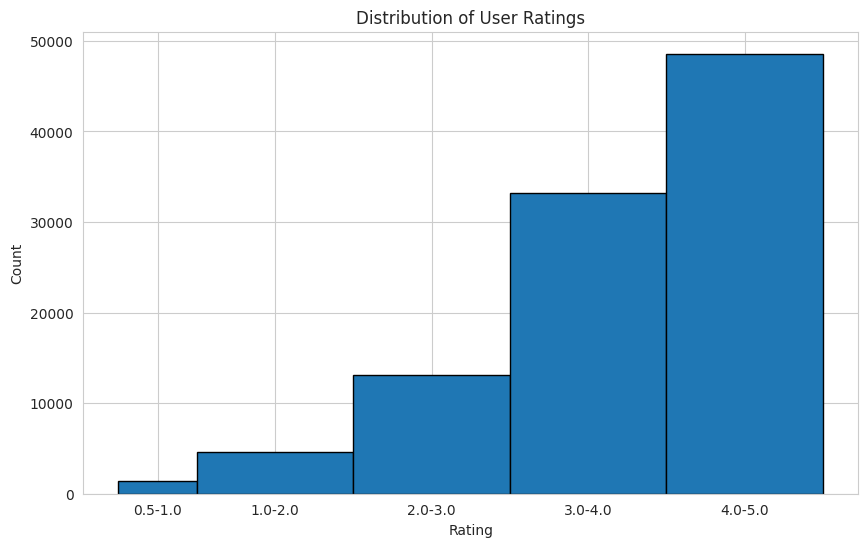

In [16]:
plt.figure(figsize=(10, 6))

# Define the bins
bins = [0.5, 1.0, 2.0, 3.0, 4.0, 5.0]

# Create the histogram
plt.hist(ratings['rating'], bins=bins, edgecolor='black')

# Customize the plot
plt.title('Distribution of User Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')

# Calculate the center of each bin
bin_centers = [(bins[i] + bins[i+1])/2 for i in range(len(bins)-1)]

# Set x-axis labels to show the bin ranges, centered on each bin
plt.xticks(bin_centers, ['0.5-1.0', '1.0-2.0', '2.0-3.0', '3.0-4.0', '4.0-5.0'])

plt.show()

Next we'll create a horizontal bar chart that displays the top 15 movies based on their average ratings, filtered for those with a minimum number of 100 ratings.

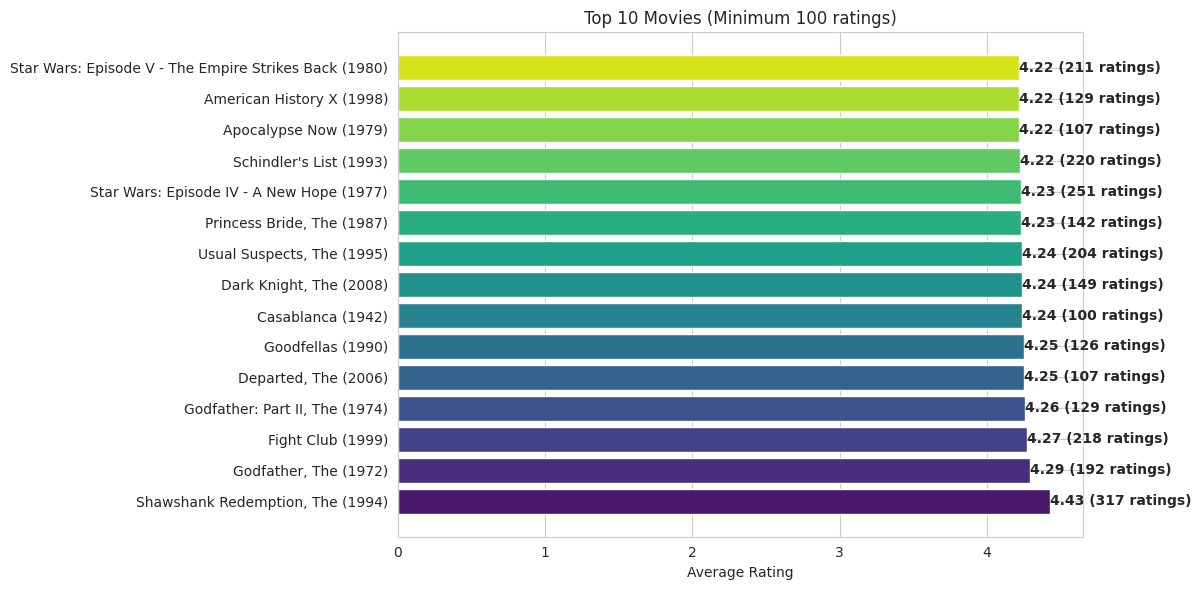


Top 15 Movies Data:
                                                title  avg_rating  num_ratings
                     Shawshank Redemption, The (1994)    4.429022          317
                                Godfather, The (1972)    4.289062          192
                                    Fight Club (1999)    4.272936          218
                       Godfather: Part II, The (1974)    4.259690          129
                                 Departed, The (2006)    4.252336          107
                                    Goodfellas (1990)    4.250000          126
                                    Casablanca (1942)    4.240000          100
                              Dark Knight, The (2008)    4.238255          149
                           Usual Suspects, The (1995)    4.237745          204
                           Princess Bride, The (1987)    4.232394          142
            Star Wars: Episode IV - A New Hope (1977)    4.231076          251
                              S

In [17]:
# Calculate average rating for each movie and number of ratings
movie_stats = ratings_with_titles.groupby('title').agg({
    'rating': ['mean', 'count']
}).reset_index()

# Flatten the column names
movie_stats.columns = ['title', 'avg_rating', 'num_ratings']

# Filter for movies with a minimum number of ratings
min_ratings = 100
popular_movies = movie_stats[movie_stats['num_ratings'] >= min_ratings]

# Sort by average rating and get top 10
top_movies = popular_movies.sort_values('avg_rating', ascending=False).head(15)

# Create the plot
plt.figure(figsize=(12, 6))
bars = plt.barh(y=range(len(top_movies)), width=top_movies['avg_rating'],
                color=sns.color_palette("viridis", len(top_movies)))

# Customize the plot
plt.yticks(range(len(top_movies)), top_movies['title'])
plt.xlabel('Average Rating')
plt.title(f'Top 10 Movies (Minimum {min_ratings} ratings)')

# Add rating annotations to the end of each bar
for i, bar in enumerate(bars):
    width = bar.get_width()
    plt.text(width, bar.get_y() + bar.get_height()/2,
             f'{top_movies["avg_rating"].iloc[i]:.2f} ({top_movies["num_ratings"].iloc[i]} ratings)',
             va='center', ha='left', fontweight='bold')

plt.tight_layout()
plt.show()

# Print the data
print("\nTop 15 Movies Data:")
print(top_movies[['title', 'avg_rating', 'num_ratings']].to_string(index=False))

Next, we'll plot a graph of the 15 most popular movies by number of ratings.

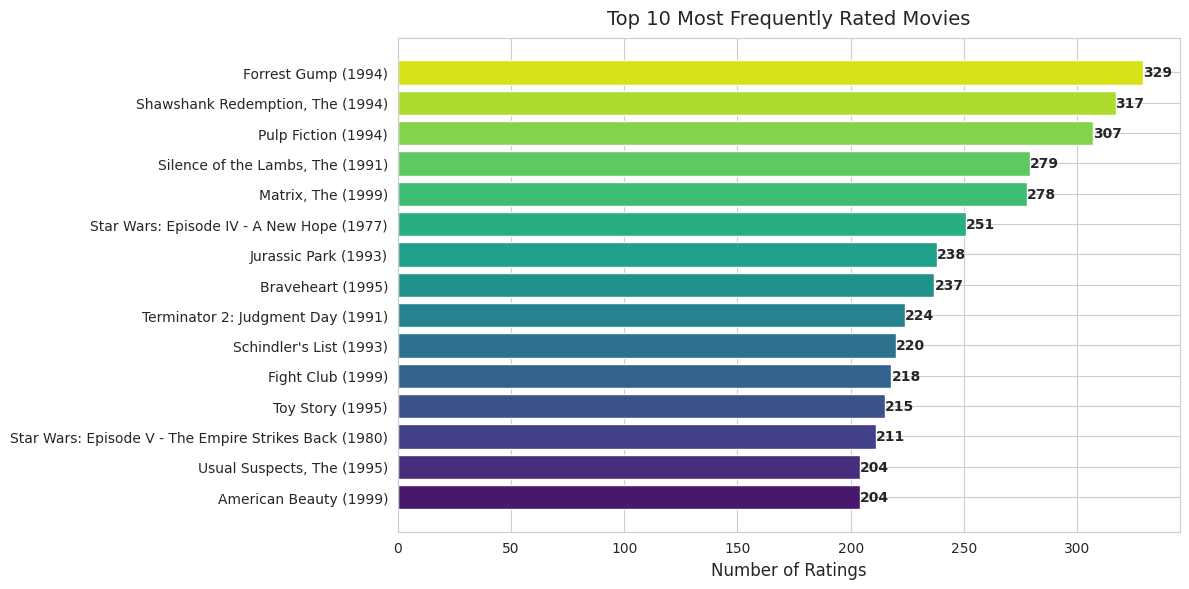


Top 15 Most Rated Movies:
                                                title  number_of_ratings
                               American Beauty (1999)                204
                           Usual Suspects, The (1995)                204
Star Wars: Episode V - The Empire Strikes Back (1980)                211
                                     Toy Story (1995)                215
                                    Fight Club (1999)                218
                              Schindler's List (1993)                220
                    Terminator 2: Judgment Day (1991)                224
                                    Braveheart (1995)                237
                                 Jurassic Park (1993)                238
            Star Wars: Episode IV - A New Hope (1977)                251
                                   Matrix, The (1999)                278
                     Silence of the Lambs, The (1991)                279
                        

In [18]:
# Group by movie title and count the number of ratings
movie_ratings_count = ratings_with_titles.groupby('title')['rating'].count().reset_index()
movie_ratings_count.columns = ['title', 'number_of_ratings']

# Sort by number of ratings and get top 15
top_rated_movies = movie_ratings_count.sort_values('number_of_ratings', ascending=True).tail(15)

# Create the plot
plt.figure(figsize=(12, 6))
bars = plt.barh(y=range(len(top_rated_movies)), width=top_rated_movies['number_of_ratings'],
                color=sns.color_palette("viridis", len(top_rated_movies)))

# Customize the plot
plt.yticks(range(len(top_rated_movies)), top_rated_movies['title'], fontsize=10)
plt.xlabel('Number of Ratings', fontsize=12)
plt.title('Top 10 Most Frequently Rated Movies', fontsize=14, pad=10)

# Add number of ratings to the end of each bar
for i, bar in enumerate(bars):
    width = bar.get_width()
    plt.text(width, bar.get_y() + bar.get_height()/2,
             f'{width:,.0f}',  # Format number with commas
             va='center', ha='left', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

# Print the data
print("\nTop 15 Most Rated Movies:")
print(top_rated_movies.to_string(index=False))

In [19]:
counts, _ = np.histogram(ratings['rating'], bins=bins)
for i, count in enumerate(counts):
    print(f"Bin {bins[i]}-{bins[i+1]}: {count}")

Bin 0.5-1.0: 1370
Bin 1.0-2.0: 4602
Bin 2.0-3.0: 13101
Bin 3.0-4.0: 33183
Bin 4.0-5.0: 48580


I'm starting with the `ratings_with_titles` df for my basic recommendation model because it contains key user-item interactions, which are essential for collaborative filtering. This dataframe shows which users rated which movies and their ratings, allowing me to identify patterns in preferences.

I'll use collaborative filtering, focusing on either:

- User-Based: Recommending movies based on the preferences of similar users.
- Item-Based: Suggesting movies based on similarities between items that users have liked.

Using `ratings_with_titles` gives me a solid foundation for identifying these relationships, and I can later integrate `movies` and `tags` dataframes for more nuanced recommendations.

Now, I'll create a scikit surprise dataset from the `ratings` dataframe.

In [20]:
# reading the values as scikit surprise dataset
reader = Reader(rating_scale=(0.5, 5.0))
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)
trainset = data.build_full_trainset()

In [21]:
# parameter grid for SVD
param_grid = {
    'n_factors': [50, 100],
    'n_epochs': [20, 30],
    'lr_all': [0.002, 0.005],
    'reg_all': [0.4, 0.6]
}

In [22]:
# create the grid search object
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3, joblib_verbose=5, n_jobs=-1)
gs.fit(data)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   28.7s
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:  1.3min finished


In [23]:
# Get the best parameters
print(gs.best_score)
print(gs.best_params)

{'rmse': 0.8825990411806007, 'mae': 0.6815529463987867}
{'rmse': {'n_factors': 50, 'n_epochs': 30, 'lr_all': 0.005, 'reg_all': 0.4}, 'mae': {'n_factors': 50, 'n_epochs': 30, 'lr_all': 0.005, 'reg_all': 0.4}}


In [24]:
# Cross validation with KNNBasic
# Parameter grid for KNNBasic
param_grid = {
    'k': [20, 40, 60],
    'min_k': [1, 2, 3],
    'sim_options': {
        'name': ['cosine', 'msd', 'pearson'],
        'user_based': [True, False]
    }
}

# Create the grid search object
gs = GridSearchCV(KNNBasic, param_grid, measures=['rmse', 'mae'], cv=3, n_jobs=-1)

# Fit the data
gs.fit(data)

# Get the best parameters and scores
print("Best RMSE:", gs.best_score['rmse'])
print("Best MAE:", gs.best_score['mae'])
print("Best Parameters:", gs.best_params['rmse'])

Best RMSE: 0.9122518343083685
Best MAE: 0.7019802295558922
Best Parameters: {'k': 60, 'min_k': 3, 'sim_options': {'name': 'msd', 'user_based': False}}


In [25]:
# These 2 code cells run faster than the cell above

# Cross validation with KNNBasic
# knn_basic = KNNBasic(sim_options={'name':'msd', 'user_based':True})
# cv_knn_basic = cross_validate(knn_basic, data, n_jobs=-1)

# and this
# Average RMSE
# for i in cv_knn_basic.items():
#     print(i)
# print('-----------------------')
# print(np.mean(cv_knn_basic['test_rmse']))

In [26]:
knn_baseline = KNNBaseline(sim_options={'name':'msd', 'user_based':True})
cv_knn_baseline = cross_validate(knn_baseline,data)

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.


In [27]:
# print out the average score for the test set
for i in cv_knn_baseline.items():
    print(i)

np.mean(cv_knn_baseline['test_rmse'])

('test_rmse', array([0.88251704, 0.8725812 , 0.87613176, 0.86104709, 0.88071585]))
('test_mae', array([0.67542939, 0.66465968, 0.67156155, 0.66091684, 0.67047395]))
('fit_time', (0.48173093795776367, 0.4966695308685303, 0.5479660034179688, 1.1577913761138916, 0.48055386543273926))
('test_time', (1.6162140369415283, 1.608140230178833, 8.748424530029297, 1.85129976272583, 1.6232457160949707))


0.8745985882564982

Based off these outputs, it seems like the best performing model is the SVD model with n_factors = 100 and a regularization rate of 0.4.

Next, I'll create a `get_movie_recommendations` function that is designed to enhance the user experience by allowing users to provide ratings for a selection of movies they've seen. It prompts users to rate five randomly chosen movies on a scale of 0.5 to 5. If a user hasn't watched a particular movie, they can simply enter 'n' to skip it.

After collecting the ratings, the function uses a trained recommendation model to predict ratings for all movies in the dataset. It then adjusts the predicted ratings based on the user's inputs and recommends the top movies tailored to their preferences. This approach ensures that users receive personalized suggestions that align with their tastes.

In [28]:
def get_movie_recommendations(user_id, ratings_with_titles, model, n_recommendations=5):
    # Prepare a sample of movies to prompt the user
    sample_movies = ratings_with_titles.sample(n=5)
    print("Please rate the following movies on a scale of 0.5 to 5 (or enter 'n' to skip):")

    user_ratings = {}

    for index, row in sample_movies.iterrows():
        title = row['title']
        # Prompt user for rating
        rating_input = input(f"Rate '{title}': ")

        if rating_input.lower() == 'n':
            continue  # Skip this movie if the user hasn't seen it

        try:
            rating = float(rating_input)
            user_ratings[row['movieId']] = rating
        except ValueError:
            print("Invalid input. Please enter a number between 0.5 and 5 or 'n' to skip.")

    # Get predictions for all movies
    all_movie_ids = ratings_with_titles['movieId'].unique()
    predictions = []

    for movie_id in all_movie_ids:
        # Use the model to predict the rating
        pred_rating = model.predict(user_id, movie_id).est

        # If the user rated this movie, adjust the prediction based on their rating
        if movie_id in user_ratings:
            adjusted_rating = (pred_rating + user_ratings[movie_id]) / 2
        else:
            adjusted_rating = pred_rating

        predictions.append((movie_id, adjusted_rating))

    # Sort predictions by adjusted rating
    predictions.sort(key=lambda x: x[1], reverse=True)

    # Recommend top N movies
    recommended_movies = predictions[:n_recommendations]

    # Convert movie IDs to titles
    recommended_titles = ratings_with_titles[ratings_with_titles['movieId'].isin([m[0] for m in recommended_movies])]

    return recommended_titles[['title', 'movieId']]

# Usage
user_id = 55  # user ID
best_model = gs.best_estimator['rmse']  # or 'mae'
best_model.fit(trainset)
recommended_movies = get_movie_recommendations(user_id, ratings_with_titles, best_model)
print("Recommended Movies:")
print(recommended_movies)

Computing the msd similarity matrix...
Done computing similarity matrix.
Please rate the following movies on a scale of 0.5 to 5 (or enter 'n' to skip):
Rate 'Last Samurai, The (2003)': 4
Rate 'Memento (2000)': 4.1
Rate 'Dirty Harry (1971)': 4.2
Rate 'First Knight (1995)': 4.3
Rate 'E.T. the Extra-Terrestrial (1982)': 4.4
Recommended Movies:
                      title  movieId
9016   Way Back, The (2010)    83369
9139       The Mummy (2017)   170827
9147           Black Mirror   176601
9153           Alpha (2018)   185031
90034            61* (2001)    27373


### Cold-Start Problem

In [29]:
# Split the genres and explode the DataFrame
movies_ratings['genres'] = movies_ratings['genres'].str.split('|')
expanded_movies = movies_ratings.explode('genres')

# Reset the index
expanded_movies.reset_index(drop=True, inplace=True)

In [30]:
# Display the result
expanded_movies.head()

,movieId,title,genres,userId,rating
0,1,Toy Story (1995),Adventure,1.0,4.0
1,1,Toy Story (1995),Animation,1.0,4.0
2,1,Toy Story (1995),Children,1.0,4.0
3,1,Toy Story (1995),Comedy,1.0,4.0
4,1,Toy Story (1995),Fantasy,1.0,4.0


In [31]:
# Get unique genres from the 'genres' column
available_genres = expanded_movies['genres'].unique()

def recommend_movies_cold(user_genres, movies_df, n=5):
    # Filter movies based on user-selected genres
    recommended_movies_cold = movies_df[movies_df['genres'].isin(user_genres)]

    # Calculate the average rating for each movie
    average_ratings = recommended_movies_cold.groupby('title')['rating'].mean().reset_index()

    # Filter for movies with an average rating of at least 4.0
    recommended_movies_cold = recommended_movies_cold.merge(average_ratings, on='title', suffixes=('', '_avg'))
    recommended_movies_cold = recommended_movies_cold[recommended_movies_cold['rating_avg'] >= 4.0]

    # Drop duplicates to ensure each movie is suggested only once
    recommended_movies_cold = recommended_movies_cold.drop_duplicates(subset='title')

    # Sort by average rating and return top N movies
    return recommended_movies_cold.sort_values(by='rating_avg', ascending=False).head(n)

# Prompt user to select genres
print("Please select up to 5 genres from the following list:")
for idx, genre in enumerate(available_genres, start=1):
    print(f"{idx}. {genre}")

# Get user input for genre selection
user_input = input("Enter the numbers of your selected genres separated by commas (e.g., 1, 2, 3): ")
selected_indices = [int(x.strip()) for x in user_input.split(',') if x.strip().isdigit()]

# Ensure user selects up to 5 genres
if len(selected_indices) > 5:
    print("You can only select up to 5 genres.")
    selected_indices = selected_indices[:5]

# Get the selected genres
user_selected_genres = [available_genres[i - 1] for i in selected_indices]

# Get recommendations based on user-selected genres
recommended = recommend_movies_cold(user_selected_genres, expanded_movies)
print(recommended[['title', 'genres', 'rating']])

Please select up to 5 genres from the following list:
1. Adventure
2. Animation
3. Children
4. Comedy
5. Fantasy
6. Romance
7. Drama
8. Action
9. Crime
10. Thriller
11. Horror
12. Mystery
13. Sci-Fi
14. War
15. Musical
16. Documentary
17. IMAX
18. Western
19. Film-Noir
20. (no genres listed)
Enter the numbers of your selected genres separated by commas (e.g., 1, 2, 3): 18
                                      title   genres  rating
1894  Trinity and Sartana Are Coming (1972)  Western     5.0
1451                 Duel in the Sun (1946)  Western     5.0
1651              7 Faces of Dr. Lao (1964)  Western     5.0
1599            Ox-Bow Incident, The (1943)  Western     4.5
1606                       Oklahoma! (1955)  Western     5.0


## Neural Networks

I got performance issues for my neural network model, so I'll be dropping any rows where any column has a null value.

In [32]:
# Drop any rows with null values in any column
movies_ratings_tags = movies_ratings_tags.dropna()

### Step 1: Data Preparation

First, we'll preprocess the data to create user-item pairs suitable for training our model.

In [33]:
# Create user-item interaction matrix
ratings = movies_ratings_tags[['userId', 'movieId', 'rating']]

In [34]:
# Create user and movie mappings
user_ids = ratings['userId'].unique()
movie_ids = ratings['movieId'].unique()

In [35]:
user_to_index = {user_id: idx for idx, user_id in enumerate(user_ids)}
movie_to_index = {movie_id: idx for idx, movie_id in enumerate(movie_ids)}

In [36]:
# Convert userId and movieId to indices
ratings['userIndex'] = ratings['userId'].map(user_to_index)
ratings['movieIndex'] = ratings['movieId'].map(movie_to_index)

In [37]:
# Split the data into training and test sets
train, test = train_test_split(ratings, test_size=0.2, random_state=42)

X_train = train[['userIndex', 'movieIndex']]
y_train = train['rating']
X_test = test[['userIndex', 'movieIndex']]
y_test = test['rating']

### Step 2: Build the Neural Network

Now we can create a simple neural network that learns from user-item interactions.

In [38]:
# Define model parameters
num_users = len(user_ids)
num_movies = len(movie_ids)
embedding_size = 50  # Size of the embedding vectors

In [39]:
# Define the model architecture
user_input = Input(shape=(1,), name='user_input')
movie_input = Input(shape=(1,), name='movie_input')

user_embedding = Embedding(num_users, embedding_size)(user_input)
movie_embedding = Embedding(num_movies, embedding_size)(movie_input)

In [40]:
# Flatten the embeddings
user_vecs = Flatten()(user_embedding)
movie_vecs = Flatten()(movie_embedding)

In [41]:
# Compute the dot product of user and movie vectors
dot_product = Dot(axes=1)([user_vecs, movie_vecs])

In [42]:
# Add a Dense layer for more learning capacity
output = Dense(1, activation='linear')(dot_product)

In [43]:
# Compile the model
model = Model(inputs=[user_input, movie_input], outputs=output)
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Print the model summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ user_input (InputLayer)   │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ movie_input (InputLayer)  │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 1, 50)          │         30,500 │ user_input[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_1 (Embedding)   │ (None, 1, 50)          │         77,700 │ movie_input[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 50)             │              0 │ embedding[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_1 (Flatten)       │ (None, 50)             │              0 │ embedding_1[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dot (Dot)                 │ (None, 1)              │              0 │ flatten[0][0],         │
│                           │                        │                │ flatten_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 1)              │              2 │ dot[0][0]              │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 108,202 (422.66 KB)

 Trainable params: 108,202 (422.66 KB)

 Non-trainable params: 0 (0.00 B)

### Step 3: Train the Model

Now, we'll train the model on the training data.

In [44]:
# Train the model
model.fit([X_train['userIndex'], X_train['movieIndex']], y_train, epochs=10, batch_size=64, validation_data=([X_test['userIndex'], X_test['movieIndex']], y_test))

Epoch 1/10
2916/2916 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 5.8084 - val_loss: 0.4229
Epoch 2/10
2916/2916 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.3569 - val_loss: 0.2708
Epoch 3/10
2916/2916 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.2079 - val_loss: 0.1846
Epoch 4/10
2916/2916 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - loss: 0.1210 - val_loss: 0.1505
Epoch 5/10
2916/2916 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 0.0734 - val_loss: 0.1363
Epoch 6/10
2916/2916 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 0.0513 - val_loss: 0.1311
Epoch 7/10
2916/2916 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.0375 - val_loss: 0.1304
Epoch 8/10
2916/2916 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.0300 - val_loss: 0.1305
Epoch 9/10
2916/2916 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0254 - val_loss: 0.1299
Epoch 10/10
2916/2916 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - loss: 0.0219 - val_loss: 0.1303


In [45]:
print("Training Data NaNs:", X_train.isnull().sum().sum(), y_train.isnull().sum())

Training Data NaNs: 0 0


In [56]:
from sklearn.metrics import mean_squared_error

# predictions on the training set
y_train_pred = model.predict([X_train['userIndex'].values, X_train['movieIndex'].values])

# RMSE for training set
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))

# predictions on the test set
y_pred = model.predict([X_test['userIndex'].values, X_test['movieIndex'].values])

# RMSE for test set
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Print the RMSE values
print(f'Training RMSE: {train_rmse}')
print(f'Test RMSE: {test_rmse}')

5831/5831 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step
1458/1458 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step
Training RMSE: 0.1373892628239876
Test RMSE: 0.3609202291016995


### Step 4: Making Recommendations

After training, we'll create a function to generate movie recommendations for a specific user based on their ratings.

In [46]:
def get_movie_recommendations(user_id, ratings_with_titles, model, n_recommendations=5):
    # Get the user's index
    user_index = user_to_index[user_id]

    # Get all movie indices
    all_movie_indices = np.arange(len(movie_ids))

    # Predict ratings for all movies
    predictions = model.predict([np.full_like(all_movie_indices, user_index), all_movie_indices])
    predictions = np.clip(predictions, 0, 5)
    print("Predictions:", predictions)  # Check the predictions for NaN values

    # Create a DataFrame for the predictions
    pred_df = pd.DataFrame({
        'movieIndex': all_movie_indices,
        'predicted_rating': predictions.flatten()
    })

    # Create a mapping of movieIndex to movieId
    movie_index_to_id = {idx: movie_id for movie_id, idx in movie_to_index.items()}
    pred_df['movieId'] = pred_df['movieIndex'].map(movie_index_to_id)

    # Merge with the original ratings to get movie titles
    recommended_movies = pred_df.merge(movies_ratings_tags[['movieId', 'title']].drop_duplicates(), on='movieId', how='left')

    # Sort by predicted rating and get the top N recommendations
    top_recommendations = recommended_movies.sort_values(by='predicted_rating', ascending=False).head(n_recommendations)

    return top_recommendations[['title', 'predicted_rating']]

# Usage
user_id = 55  # user ID
recommended_movies = get_movie_recommendations(user_id, movies_ratings_tags, model)
print("Recommended Movies:")
print(recommended_movies)

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Predictions: [[2.4795358]
 [2.2397332]
 [1.162058 ]
 ...
 [1.9934478]
 [2.235106 ]
 [2.1214767]]
Recommended Movies:
                            title  predicted_rating
1414  (500) Days of Summer (2009)          4.980034
1353         Departed, The (2006)          4.879723
1375                  Juno (2007)          4.665024
1274            Layer Cake (2004)          4.583743
51           Billy Madison (1995)          4.511504
